# 목표
## 1. 머신러닝 regression이용하기 + 랜덤포레스트로 feature importance확인
special_bmi, 혈당, 고혈압 여부를 건강수치 라벨로 하고 regression을 진행한다. linear regression을 이용해 선을 보여준다. 그리고 여러가지 것들을 이용해 학습한다. 랜덤포레스트로 학습해서 피쳐importances들을 확인한다. 그리고 정확도를 높인다. (트레인 셋에 허리둘레 체중 신장처럼 bmi에 직접적인 영향이 있는 항목은 지우고 학습한다.)
## 2. HDL LDL이 각각 건강에 미치는 영향을 계산하기(HDL은 건강에 좋고 LDL은 건강에 안좋을것이다) 
HDL과 LDL을 나눠서 각각 새로운 카테고리로 나눈다. 그리고 이 둘만 따로 해서 bmi나 혹은 혈압같은 다른 건강에 악영향을 미치는 요인을 라벨로 해서 통계를 내보거나 머신러닝을 이용한다. 어떻게 머신러닝을 이용할까? linear regression을 이용해서 선을 보여줄까?  

### bmi의 경우 근육질 몸이여서 bmi가 높은경우일 수 있으므로 허리둘레에 bmi를 나눈 값을 이용한다. 그러면 상대적으로 뱃살만 나온 몸매를 걸러낼 수 있다.

### 1. matplotlib을 import 하고 폰트가 깨져서 다른 폰트를 import 했습니다.

In [3]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')
path = 'C:/Windows/Fonts/gulim.ttc'
font_name = fm.FontProperties(fname=path, size=50).get_name()
print(font_name)
plt.rc('font', family=font_name)

Gulim


### 1. 필요한 라이브러리 import 했습니다
### 2. 혈액데이터의 칼럼을 height와 weight로 이름을 바꾸고(편의성을 위해) bmi라는 새로운 칼럼을 만들었습니다
### 3. 그리고 허리둘레와 bmi를 나눠서 special bmi라는 칼럼도 생성했습니다. 왜냐하면 근육질인 사람은 bmi가 높아도 허리둘레는 상대적으로 낮기 때문입니다. 그래서 bmi만으로는 건강하다는것을 파악하기 힘들다고 생각했습니다.
### 4. 그리고 필요없는 칼럼들은 삭제를 해주고 null값이 있는 행을 삭제합니다.
### 5. 중요한 데이터인 hdl과 ldl에 이상치가 있어 제거를 해줬습니다.

In [18]:
import pandas as pd
import numpy as np


blood_data=pd.read_csv('blood.csv',engine='python',encoding='CP949')

blood_data.rename(columns = {'신장(5Cm단위)' : 'height'}, inplace = True)
blood_data.rename(columns = {'체중(5Kg단위)' : 'weight'}, inplace = True)

blood_data['bmi']=blood_data['weight']/(blood_data['height']**2/10000)
blood_data['special_bmi']=blood_data['허리둘레']/blood_data['bmi']
blood_data=blood_data.drop(blood_data.columns[[8,9,10,11]], axis='columns')
blood_data=blood_data.drop(blood_data.columns[[22,23,24,25,26,27,28,29]], axis='columns')
blood_data=blood_data.drop(blood_data.columns[[0,1,4]], axis='columns')
blood_data=blood_data.drop(blood_data.columns[[2,3]], axis='columns')
blood_data=blood_data.dropna(axis=0)
blood_data=blood_data[blood_data['LDL콜레스테롤']>75]
blood_data=blood_data[blood_data['HDL콜레스테롤']<130]

blood_data.head()

,성별코드,연령대코드(5세단위),허리둘레,수축기혈압,이완기혈압,식전혈당(공복혈당),총콜레스테롤,트리글리세라이드,HDL콜레스테롤,LDL콜레스테롤,혈색소,요단백,혈청크레아티닌,(혈청지오티)AST,(혈청지오티)ALT,감마지티피,흡연상태,bmi,special_bmi
0,1,10,86.0,140.0,90.0,91.0,263.0,196.0,46.0,177.0,16.0,1.0,0.9,27.0,30.0,45.0,3.0,24.489796,3.511667
1,2,11,85.0,138.0,80.0,105.0,185.0,262.0,35.0,122.0,13.1,1.0,0.9,18.0,17.0,19.0,1.0,25.390625,3.347692
2,2,11,80.0,138.0,88.0,93.0,246.0,186.0,59.0,150.0,13.6,1.0,0.7,23.0,19.0,64.0,1.0,24.444444,3.272727
3,1,12,85.0,124.0,76.0,93.0,179.0,79.0,40.0,123.0,16.8,1.0,1.0,20.0,39.0,69.0,2.0,22.857143,3.718750
4,2,6,67.0,121.0,68.0,96.0,223.0,104.0,72.0,130.0,12.8,1.0,0.7,13.0,7.0,20.0,1.0,19.531250,3.430400


### 1. 허리둘레 칼럼도 special bmi에 들어가 있으므로 제거합니다.

In [19]:
blood_data=blood_data.drop(blood_data.columns[[2]], axis='columns') #허리둘레 제거

## LDL과 HDL의 건강과의 상관관계

주장1 : HDL은 건강에 좋고 LDL은 나쁘다. 그래서 총 콜레스테롤이 높아도 HDL이 높고 LDL이 정상이면 bmi나 허리둘레나 다른 결과들이 좋게 나타날 것이다. 
주장2 : 반대로 LDL이높고 HDL이 낮은경우는 건강이 매우 안좋다(bmi)는 신호일것이다.

주장3 : LDL수치와 HDL수치가 둘다 높거나 낮은경우도 건강이 좋지만은 않을것이다.
1. LDL수치와 HDL수치가 둘다 높은 경우
2. HDL수치가 높고 LDL수치는 정상이거나 낮은경우
3. HDL수치가 정상이고 LDL수치가 높은 경우
4. HDL수치와 LDL수치가 둘다 낮은 경우(총콜레스테롤이 낮은경우)


LDL-콜레스테롤

< 100
정상 (optimal)

100 ~ 129
정상 이상 (near optimal/above optimal)

130 ~ 159
약간 높음 (borderline high)

160 ~ 189
높음 (high)

190 이상
아주 높음 (very high)


총콜레스테롤

< 200
적절 (desirable)

200 ~ 239
약간 높음 (borderline high)

240 이상
높음 (high)


HDL-콜레스테롤

< 40
낮음 (low)

60 이상
높음 (high)

### 총콜레스테롤과 LDL과 HDL수치를 카테고리로 나눠줬습니다.

In [20]:
b_data=blood_data


b_data["LDL_cat"] = pd.cut(b_data["LDL콜레스테롤"],
                               bins=[0., 100., 130.,160., 190., np.inf],
                               labels=[1, 2, 3, 4, 5])

b_data["HDL_cat"] = pd.cut(b_data["HDL콜레스테롤"],
                               bins=[0.,40.,60., np.inf],
                               labels=[0,1,2])

b_data["TC_cat"] = pd.cut(b_data["총콜레스테롤"],
                               bins=[0.,200.,240., np.inf],
                               labels=[1,2,3])

In [21]:
b_data.head()

,성별코드,연령대코드(5세단위),수축기혈압,이완기혈압,식전혈당(공복혈당),총콜레스테롤,트리글리세라이드,HDL콜레스테롤,LDL콜레스테롤,혈색소,...,혈청크레아티닌,(혈청지오티)AST,(혈청지오티)ALT,감마지티피,흡연상태,bmi,special_bmi,LDL_cat,HDL_cat,TC_cat
0,1,10,140.0,90.0,91.0,263.0,196.0,46.0,177.0,16.0,...,0.9,27.0,30.0,45.0,3.0,24.489796,3.511667,4,1,3
1,2,11,138.0,80.0,105.0,185.0,262.0,35.0,122.0,13.1,...,0.9,18.0,17.0,19.0,1.0,25.390625,3.347692,2,0,1
2,2,11,138.0,88.0,93.0,246.0,186.0,59.0,150.0,13.6,...,0.7,23.0,19.0,64.0,1.0,24.444444,3.272727,3,1,3
3,1,12,124.0,76.0,93.0,179.0,79.0,40.0,123.0,16.8,...,1.0,20.0,39.0,69.0,2.0,22.857143,3.718750,2,0,1
4,2,6,121.0,68.0,96.0,223.0,104.0,72.0,130.0,12.8,...,0.7,13.0,7.0,20.0,1.0,19.531250,3.430400,2,2,2


In [22]:
b_data.columns

Index(['성별코드', '연령대코드(5세단위)', '수축기혈압', '이완기혈압', '식전혈당(공복혈당)', '총콜레스테롤',
       '트리글리세라이드', 'HDL콜레스테롤', 'LDL콜레스테롤', '혈색소', '요단백', '혈청크레아티닌',
       '(혈청지오티)AST', '(혈청지오티)ALT', '감마지티피', '흡연상태', 'bmi', 'special_bmi',
       'LDL_cat', 'HDL_cat', 'TC_cat'],
      dtype='object')

# 랜덤포레스트를 이용해서 feature importances 찾아내기(첫번째 라벨 bmi 두번째라벨 식전혈당 세번째 라벨 혈압 이용)

### test set과 train set을 나눠준다

In [23]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(b_data, test_size=0.2, random_state=42)

### y 라벨로 쓸 것들을 X에서 제거한다

In [24]:
train_X=train_set.drop(['이완기혈압', '식전혈당(공복혈당)','special_bmi','수축기혈압'], axis='columns')
train_X=train_X.iloc[:,:13]

In [25]:
test_X=test_set.drop(['이완기혈압', '식전혈당(공복혈당)','special_bmi','수축기혈압'], axis='columns')
test_X=test_X.iloc[:,:13]

### 첫번째 라벨 special_bmi를 y로 넣어준다.

In [29]:
train_yb=train_set['special_bmi']

In [30]:
train_yb

770642    3.305893
54456     3.863462
836759    3.844000
518463    3.139063
340397    3.520545
            ...   
297638    3.242667
420299    3.359625
151496    3.015111
770790    3.062500
140075    3.465846
Name: special_bmi, Length: 696564, dtype: float64

In [31]:
test_yb=test_set['special_bmi']

### 좀 더 나은 성능을 위해 standardscaler로 scale을 해준다.

In [32]:
from sklearn.preprocessing import StandardScaler
stds = StandardScaler()
train_scaled=stds.fit_transform(train_X)

### grid search를 이용해 최적의 하이퍼파라미터 값들을 찾는다. 모델은 randomforest를 사용한다. (시간이 너무 오래걸려서 데이터를 20000개로 줄였습니다)

In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [20,50,100,], 'max_features': [2, 4, 6]}]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(train_scaled[:20000], train_yb[:20000])

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6],
                          'n_estimators': [20, 50, 100]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [34]:
grid_search.best_params_

{'max_features': 2, 'n_estimators': 100}

In [35]:
grid_search.best_estimator_.fit(train_scaled, train_yb)

RandomForestRegressor(max_features=2, random_state=42)

In [36]:
model=grid_search.best_estimator_
model.feature_importances_

array([0.01032564, 0.06560921, 0.11985181, 0.14588776, 0.10721183,
       0.11255062, 0.10391904, 0.00962465, 0.05391356, 0.08444401,
       0.08807609, 0.0899103 , 0.00867548])

In [37]:
train_X.head()

,성별코드,연령대코드(5세단위),총콜레스테롤,트리글리세라이드,HDL콜레스테롤,LDL콜레스테롤,혈색소,요단백,혈청크레아티닌,(혈청지오티)AST,(혈청지오티)ALT,감마지티피,흡연상태
770642,1,13,211.0,260.0,41.0,118.0,17.3,2.0,1.3,29.0,25.0,50.0,3.0
54456,1,8,215.0,142.0,54.0,133.0,15.6,1.0,0.9,22.0,23.0,33.0,2.0
836759,2,9,241.0,63.0,87.0,141.0,12.8,1.0,0.7,14.0,12.0,16.0,1.0
518463,1,9,253.0,174.0,64.0,154.0,14.6,1.0,0.9,33.0,35.0,37.0,3.0
340397,1,6,207.0,69.0,57.0,136.0,15.6,1.0,1.1,24.0,19.0,18.0,1.0


In [38]:
from sklearn.metrics import mean_squared_error
test_scaled=stds.transform(test_X)
b_predictions = model.predict(test_scaled)
lin_mse = mean_squared_error(test_yb, b_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

0.5385931365606699

In [39]:
train_ys=train_set['식전혈당(공복혈당)']
test_ys=test_set['식전혈당(공복혈당)']

In [40]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [20,50,100,], 'max_features': [2, 4, 6]}]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(train_scaled[:20000], train_ys[:20000])

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6],
                          'n_estimators': [20, 50, 100]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [41]:
grid_search.best_params_

{'max_features': 2, 'n_estimators': 100}

In [42]:
grid_search.best_estimator_.fit(train_scaled, train_ys)

RandomForestRegressor(max_features=2, random_state=42)

In [43]:
model=grid_search.best_estimator_
model.feature_importances_

array([0.0097786 , 0.072537  , 0.10190078, 0.12860753, 0.09143805,
       0.09775952, 0.10098959, 0.02126389, 0.06004124, 0.09629258,
       0.09233779, 0.1070358 , 0.02001762])

In [44]:
from sklearn.metrics import mean_squared_error
test_scaled=stds.transform(test_X)
b_predictions = model.predict(test_scaled)
lin_mse = mean_squared_error(test_ys, b_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

21.949468827676398

In [45]:
train_yp=train_set[['이완기혈압','수축기혈압']]
test_yp=test_set[['이완기혈압','수축기혈압']]

In [46]:
train_yp["고혈압_1"] = pd.cut(train_yp["이완기혈압"],
                               bins=[0., 90.,np.inf],
                               labels=[0,1])
train_yp["고혈압_2"] = pd.cut(train_yp["수축기혈압"],
                               bins=[0., 140.,np.inf],
                               labels=[0,1])


<ipython-input-46-bdac9cfb01d2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_yp["고혈압_1"] = pd.cut(train_yp["이완기혈압"],
<ipython-input-46-bdac9cfb01d2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_yp["고혈압_2"] = pd.cut(train_yp["수축기혈압"],


In [47]:
test_yp["고혈압_1"] = pd.cut(test_yp["이완기혈압"],
                               bins=[0., 90.,np.inf],
                               labels=[0,1])
test_yp["고혈압_2"] = pd.cut(test_yp["수축기혈압"],
                               bins=[0., 140.,np.inf],
                               labels=[0,1])

<ipython-input-47-a63a2b9a0053>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_yp["고혈압_1"] = pd.cut(test_yp["이완기혈압"],
<ipython-input-47-a63a2b9a0053>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_yp["고혈압_2"] = pd.cut(test_yp["수축기혈압"],


In [48]:
train_yp['고혈압']=train_yp['고혈압_1'].astype('float')+train_yp['고혈압_2'].astype('float')
train_yp['고혈압']=np.ceil(train_yp['고혈압']/2)
train_yp=train_yp['고혈압']

<ipython-input-48-fda7180b44e6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_yp['고혈압']=train_yp['고혈압_1'].astype('float')+train_yp['고혈압_2'].astype('float')
<ipython-input-48-fda7180b44e6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_yp['고혈압']=np.ceil(train_yp['고혈압']/2)


In [49]:
test_yp['고혈압']=test_yp['고혈압_1'].astype('float')+test_yp['고혈압_2'].astype('float')
test_yp['고혈압']=np.ceil(test_yp['고혈압']/2)
test_yp=test_yp['고혈압']

<ipython-input-49-0d8392ba1cce>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_yp['고혈압']=test_yp['고혈압_1'].astype('float')+test_yp['고혈압_2'].astype('float')
<ipython-input-49-0d8392ba1cce>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_yp['고혈압']=np.ceil(test_yp['고혈압']/2)


In [50]:
train_yp

770642    0.0
54456     0.0
836759    1.0
518463    0.0
340397    0.0
         ... 
297638    1.0
420299    0.0
151496    0.0
770790    1.0
140075    0.0
Name: 고혈압, Length: 696564, dtype: float64

In [51]:
from sklearn.ensemble import RandomForestClassifier

In [52]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [20,50,100], 'max_features': [2, 4, 6]}]

forest_reg = RandomForestClassifier(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(train_scaled[:20000], train_yp[:20000])

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid=[{'max_features': [2, 4, 6],
                          'n_estimators': [20, 50, 100]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [53]:
grid_search.best_params_

{'max_features': 2, 'n_estimators': 100}

In [54]:
grid_search.best_estimator_.fit(train_scaled, train_yp)

MemoryError: could not allocate 14680064 bytes

In [ ]:
model=grid_search.best_estimator_
model.feature_importances_

In [ ]:
from sklearn.metrics import accuracy_score
test_scaled=stds.transform(test_X)
b_predictions = model.predict(test_scaled)
accuracy_score(test_yp, b_predictions)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [20,50,100], 'max_features': [2, 4, 6]}]

forest_reg = RandomForestClassifier(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(train_scaled[:20000], train_yp[:20000])

In [ ]:
grid_search.best_params_

In [ ]:
grid_search.best_estimator_.fit(train_scaled, train_yp)

In [ ]:
model=grid_search.best_estimator_
model.feature_importances_

In [ ]:
from sklearn.metrics import accuracy_score
test_scaled=stds.transform(test_X)
b_predictions = model.predict(test_scaled)
accuracy_score(test_yp, b_predictions)

LDL과 HDL의 건강과의 상관관계
주장1 : HDL은 건강에 좋고 LDL은 나쁘다. 그래서 총 콜레스테롤이 높아도 HDL이 높고 LDL이 정상이면 bmi나 허리둘레나 다른 결과들이 좋게 나타날 것이다. 주장2 : 반대로 LDL이높고 HDL이 낮은경우는 건강이 매우 안좋다(bmi)는 신호일것이다.

주장3 : LDL수치와 HDL수치가 둘다 높거나 낮은경우도 건강이 좋지만은 않을것이다.

LDL수치와 HDL수치가 둘다 높은 경우
HDL수치가 높고 LDL수치는 정상이거나 낮은경우
HDL수치가 정상이고 LDL수치가 높은 경우
HDL수치와 LDL수치가 둘다 낮은 경우(총콜레스테롤이 낮은경우)
LDL-콜레스테롤

< 100 정상 (optimal)

100 ~ 129 정상 이상 (near optimal/above optimal)

130 ~ 159 약간 높음 (borderline high)

160 ~ 189 높음 (high)

190 이상 아주 높음 (very high)

총콜레스테롤

< 200 적절 (desirable)

200 ~ 239 약간 높음 (borderline high)

240 이상 높음 (high)

HDL-콜레스테롤

< 40 낮음 (low)

60 이상 높음 (high)

In [43]:
[0.01014064, 0.07567166, 0.10348085, 0.12594064, 0.09083637,
       0.10169866, 0.09890445, 0.02157921, 0.06011809, 0.09414882,
       0.09217839, 0.10551687, 0.01978535]

[0.01014064,
 0.07567166,
 0.10348085,
 0.12594064,
 0.09083637,
 0.10169866,
 0.09890445,
 0.02157921,
 0.06011809,
 0.09414882,
 0.09217839,
 0.10551687,
 0.01978535]

In [44]:
train_X.columns

Index(['성별코드', '연령대코드(5세단위)', '총콜레스테롤', '트리글리세라이드', 'HDL콜레스테롤', 'LDL콜레스테롤',
       '혈색소', '요단백', '혈청크레아티닌', '(혈청지오티)AST', '(혈청지오티)ALT', '감마지티피', '흡연상태'],
      dtype='object')

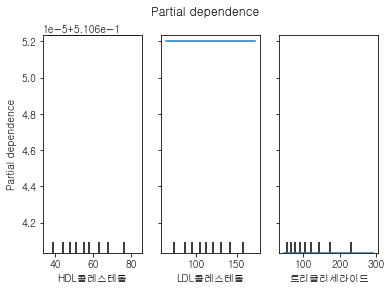

In [49]:
import matplotlib.pyplot as plt
from sklearn.inspection import plot_partial_dependence
features = ['HDL콜레스테롤','LDL콜레스테롤','트리글리세라이드']
plot_partial_dependence(model, train_X[:20000], features, target=1) 
fig = plt.gcf()
fig.suptitle('Partial dependence')
fig.subplots_adjust(hspace=0.3)